In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [80]:
def fetch_spy_data(start_date, end_date, interval='1d'):
    """
    Fetch SPY data using yfinance API
    """
    spy = yf.Ticker("SPY")
    df = spy.history(start=start_date, end=end_date, interval=interval)
    df = df.reset_index()
    return df


In [81]:
def calculate_atr(data, period=14):
    """
    Calculate the Average True Range (ATR) and add it to the DataFrame.
    """
    data = data.copy()
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift())
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift())

    data['True Range'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['True Range'].rolling(window=period).mean()

    # Drop intermediate columns
    data.drop(['High-Low', 'High-Close', 'Low-Close', 'True Range'], axis=1, inplace=True)
    return data

In [87]:
def generate_dynamic_grid_levels(price, atr, base_grid_spacing_pct=0.2, num_levels=10, vol_multiplier=1.5):
    """
    Generate dynamic grid levels based on ATR
    """
    # Calculate dynamic grid spacing using ATR
    atr_pct = (atr / price) * 100
    dynamic_grid_spacing_pct = base_grid_spacing_pct * (1 + (atr_pct * vol_multiplier))
    
    grid_spacing = price * (dynamic_grid_spacing_pct / 100)
    levels_above = np.array([price + (i * grid_spacing) for i in range(1, num_levels + 1)])  # Start from 1 to avoid price level
    levels_below = np.array([price - (i * grid_spacing) for i in range(1, num_levels + 1)])  # Start from 1 to avoid price level
    
    return np.sort(np.concatenate([levels_below, levels_above])), dynamic_grid_spacing_pct

In [88]:
def generate_dynamic_grid_signals(data, base_grid_spacing_pct=0.2, vol_multiplier=1.5):
    """
    Generate trading signals based on dynamic grid levels with error handling
    """
    data = data.copy()
    
    # Calculate ATR
    data = calculate_atr(data)
    
    # Initialize columns
    data['Signal'] = 0
    data['Grid_Level'] = 0.0
    data['Grid_Spacing_Pct'] = 0.0
    
    # Wait for ATR to be calculated (avoid NaN values)
    start_idx = data['ATR'].first_valid_index()
    if start_idx is None:
        return data
        
    for i in range(start_idx + 1, len(data)):
        current_price = data['Close'].iloc[i]
        prev_price = data['Close'].iloc[i-1]
        current_atr = data['ATR'].iloc[i]
        
        if pd.isna(current_atr):
            continue
            
        # Generate dynamic grid levels
        grid_levels, dynamic_spacing = generate_dynamic_grid_levels(
            prev_price, 
            current_atr,
            base_grid_spacing_pct,
            vol_multiplier=vol_multiplier
        )
        
        # Store the dynamic grid spacing percentage
        data.loc[data.index[i], 'Grid_Spacing_Pct'] = dynamic_spacing
        
        # Find nearest grid levels with error handling
        levels_above = grid_levels[grid_levels > prev_price]
        levels_below = grid_levels[grid_levels < prev_price]
        
        nearest_level_above = levels_above.min() if len(levels_above) > 0 else None
        nearest_level_below = levels_below.max() if len(levels_below) > 0 else None
        
        # Signal generation logic with dynamic grid levels
        if prev_price < current_price and nearest_level_above is not None:  # Price moving up
            if current_price > nearest_level_above:
                data.loc[data.index[i], 'Signal'] = -1
                data.loc[data.index[i], 'Grid_Level'] = nearest_level_above
        elif prev_price > current_price and nearest_level_below is not None:  # Price moving down
            if current_price < nearest_level_below:
                data.loc[data.index[i], 'Signal'] = 1
                data.loc[data.index[i], 'Grid_Level'] = nearest_level_below
    
    return data

In [84]:
def backtest_dynamic_grid_strategy(data, initial_capital=100000, transaction_cost=0.001):
    """
    Backtest the dynamic grid trading strategy with position sizing based on volatility
    """
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Price'] = data['Close']
    portfolio['Signal'] = data['Signal']
    portfolio['Grid_Level'] = data['Grid_Level']
    portfolio['Grid_Spacing_Pct'] = data['Grid_Spacing_Pct']
    portfolio['ATR'] = data['ATR']
    
    # Initialize portfolio metrics
    portfolio['Position'] = 0
    portfolio['Cash'] = initial_capital
    portfolio['Holdings'] = 0
    portfolio['Portfolio_Value'] = initial_capital
    
    position = 0
    cash = initial_capital
    
    for i in range(1, len(portfolio)):
        price = portfolio['Price'].iloc[i]
        signal = portfolio['Signal'].iloc[i]
        grid_spacing_pct = portfolio['Grid_Spacing_Pct'].iloc[i]
        
        # Adjust position sizing based on grid spacing (volatility)
        base_position_pct = 0.1  # Base 10% position size
        position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
        position_pct = min(max(position_pct, 0.05), 0.15)  # Cap between 5% and 15%
        
        # Execute trades based on signals
        if signal == 1:  # Buy signal
            shares_to_buy = (cash * position_pct) // price
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                if cost <= cash:
                    position += shares_to_buy
                    cash -= cost
                    
        elif signal == -1:  # Sell signal
            if position > 0:
                shares_to_sell = position * position_pct
                revenue = shares_to_sell * price * (1 - transaction_cost)
                position -= shares_to_sell
                cash += revenue
        
        # Update portfolio metrics
        portfolio.loc[portfolio.index[i], 'Position'] = position
        portfolio.loc[portfolio.index[i], 'Cash'] = cash
        portfolio.loc[portfolio.index[i], 'Holdings'] = position * price
        portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = cash + (position * price)
    
    return portfolio

In [85]:
def plot_dynamic_results(data, portfolio):
    """
    Plot trading results with additional volatility metrics
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))
    
    # Plot 1: Price and Signals
    ax1.plot(data.index, data['Close'], label='SPY Price', alpha=0.5)
    
    # Plot buy signals
    buys = data[data['Signal'] == 1]
    ax1.scatter(buys.index, buys['Close'], 
               color='green', marker='^', s=100, label='Buy Signal')
    
    # Plot sell signals
    sells = data[data['Signal'] == -1]
    ax1.scatter(sells.index, sells['Close'], 
               color='red', marker='v', s=100, label='Sell Signal')
    
    ax1.set_title('SPY Price and Dynamic Grid Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value
    ax2.plot(portfolio.index, portfolio['Portfolio_Value'], 
             label='Portfolio Value', color='blue')
    ax2.set_title('Portfolio Value Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Grid Spacing % (Volatility Indicator)
    ax3.plot(portfolio.index, portfolio['Grid_Spacing_Pct'], 
             label='Dynamic Grid Spacing %', color='purple')
    ax3.set_title('Dynamic Grid Spacing Percentage Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Grid Spacing %')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  position_pct = base_position_pct * (0.2 / grid_spacing_pct)  # Adjust based on volatility
/tmp/ipykernel_2836/4000853594.py:28: RuntimeWarni

Total Return: 27.69%
Total Trades: 527
Final Portfolio Value: $127,691.55
Average Grid Spacing: 0.67%


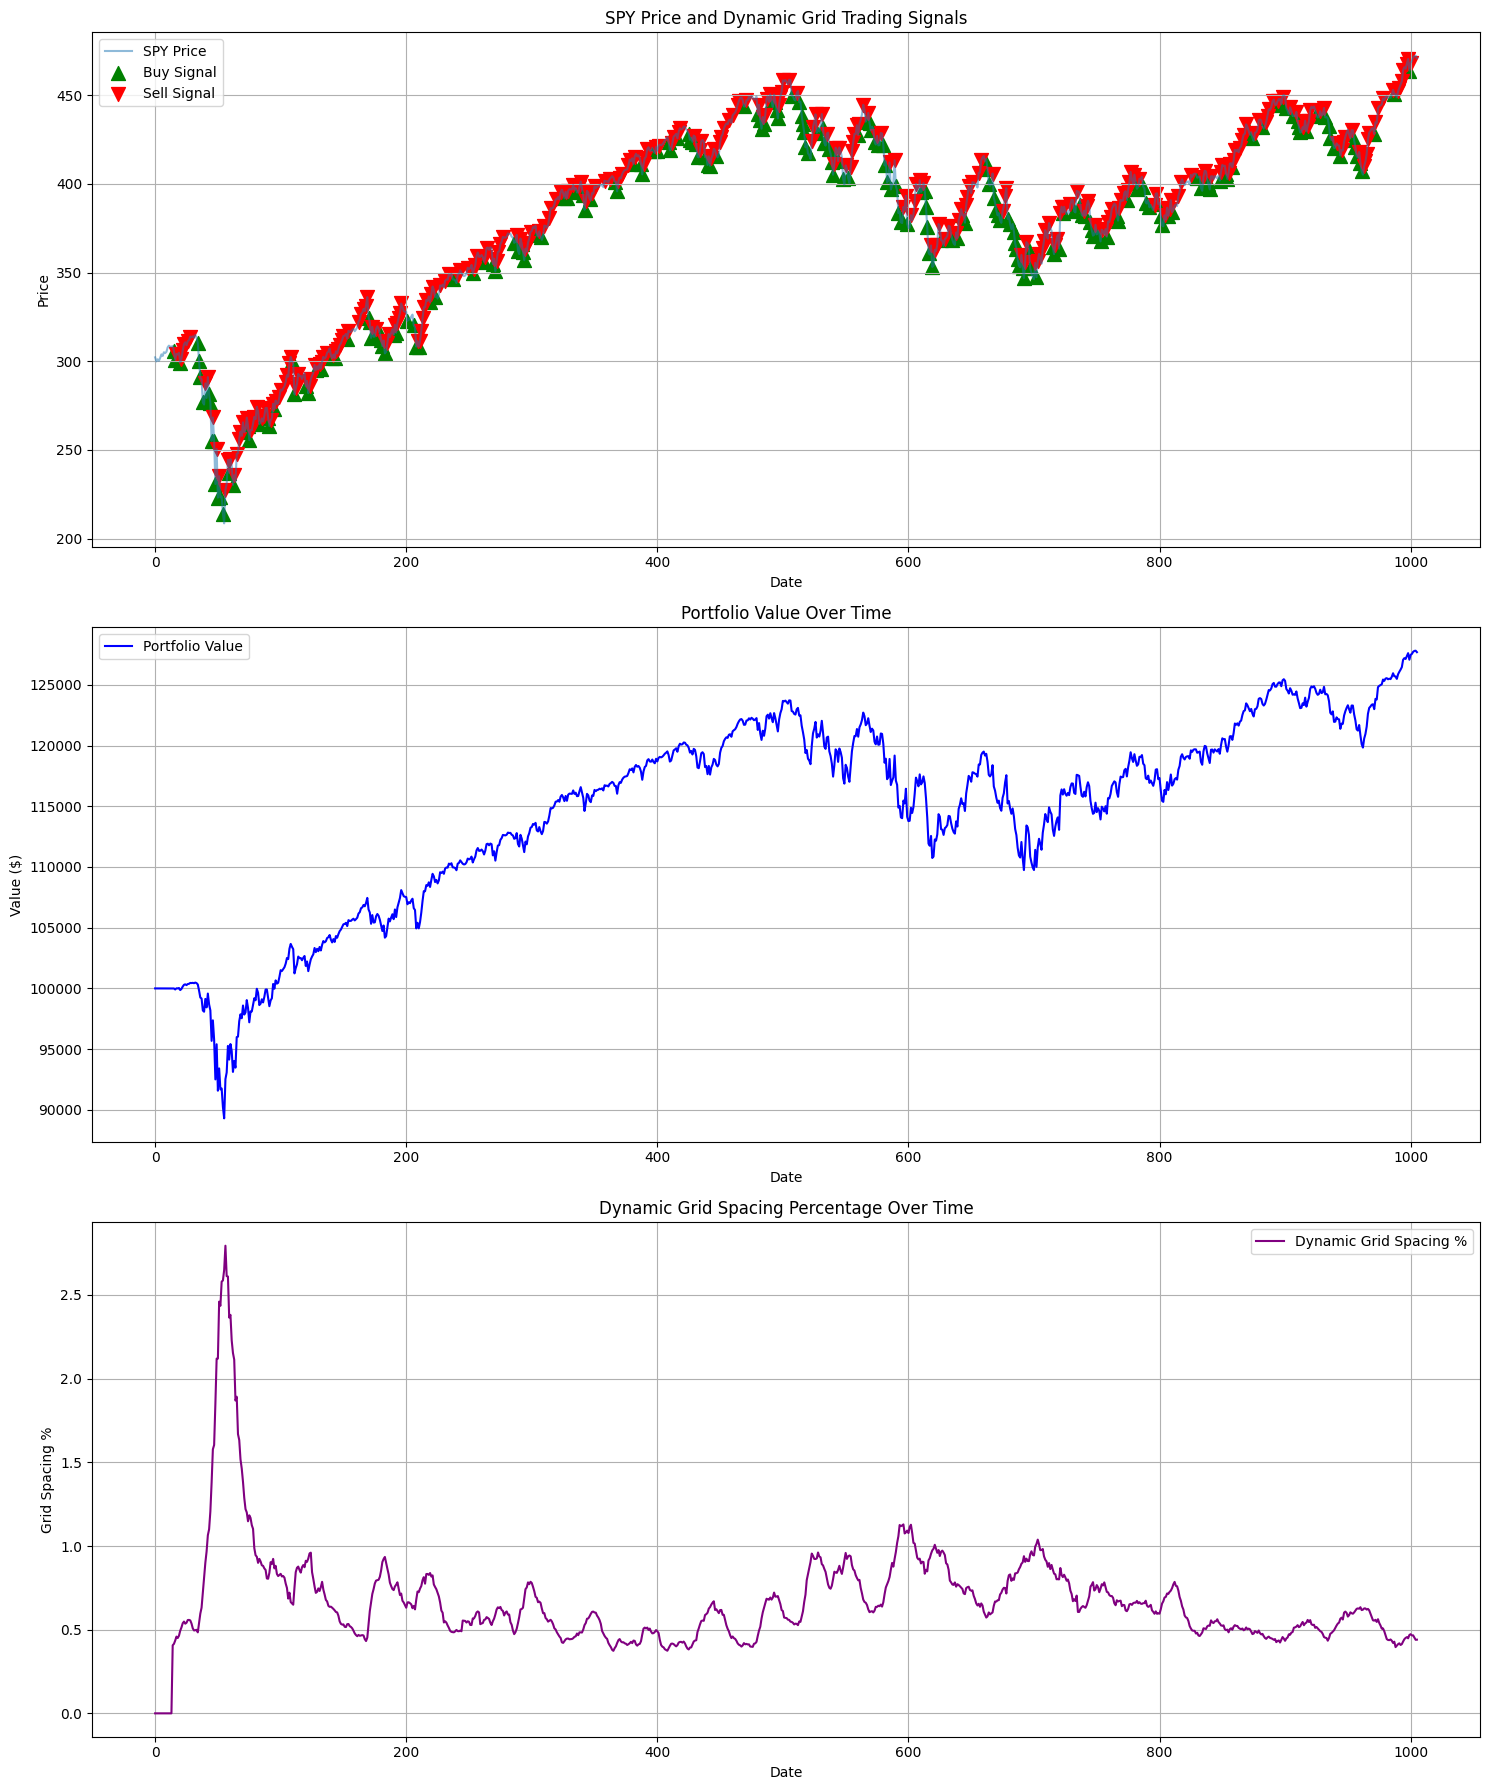

In [89]:
start_date = '2020-01-01'
end_date = '2023-12-31'
base_grid_spacing_pct = 0.2
vol_multiplier = 1.5
initial_capital = 100000

# Fetch data and generate signals
data = fetch_spy_data(start_date, end_date)
data = generate_dynamic_grid_signals(data, base_grid_spacing_pct, vol_multiplier)

# Run backtest
portfolio = backtest_dynamic_grid_strategy(data, initial_capital)

# Calculate and display metrics
total_return = (portfolio['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
total_trades = len(data[data['Signal'] != 0])
avg_grid_spacing = portfolio['Grid_Spacing_Pct'].mean()

print(f"Total Return: {total_return:.2f}%")
print(f"Total Trades: {total_trades}")
print(f"Final Portfolio Value: ${portfolio['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Average Grid Spacing: {avg_grid_spacing:.2f}%")

# Plot results
plot_dynamic_results(data, portfolio)